In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import os

plt.style.use('seaborn-v0_8')

# Create output folders
os.makedirs('../results/outputs', exist_ok=True)
os.makedirs('../results/eda_visualizations', exist_ok=True)


Missing values per column:
 No            0
year          0
month         0
day           0
hour          0
PM2.5       750
PM10        553
SO2         663
NO2        1601
CO         3197
O3          664
TEMP         20
PRES         20
DEWP         20
RAIN         20
wd           78
WSPM         14
station       0
dtype: int64


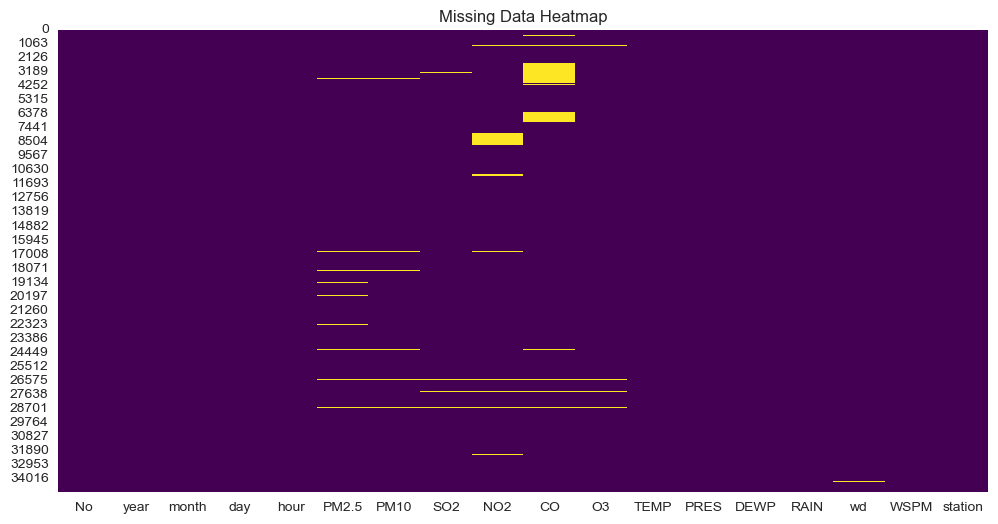

In [6]:
df = pd.read_csv('C:\\Users\\ASUS TUF\\Documents\\PG191\\data\\raw\\PRSA_Data_Dongsi_20130301-20170228.csv')

# Missing value check
missing_counts = df.isnull().sum()
print("Missing values per column:\n", missing_counts)

# EDA: Missing data heatmap
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.savefig('../results/eda_visualizations/missing_data_heatmap.png')
plt.show()

# Fill numeric missing values with median
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

df.to_csv('../results/outputs/handled_missing_data.csv', index=False)


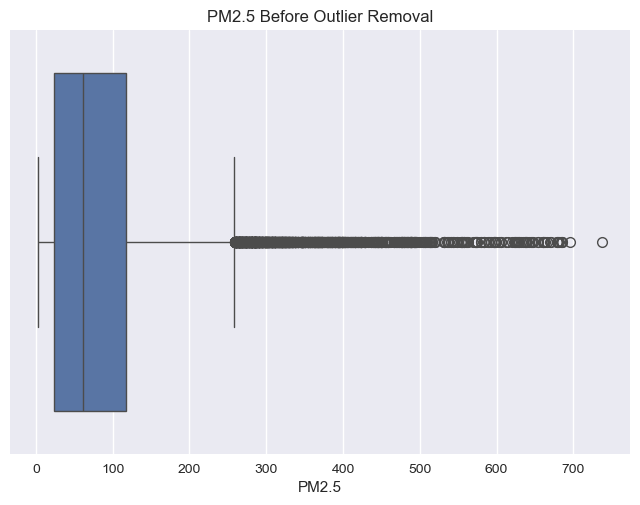

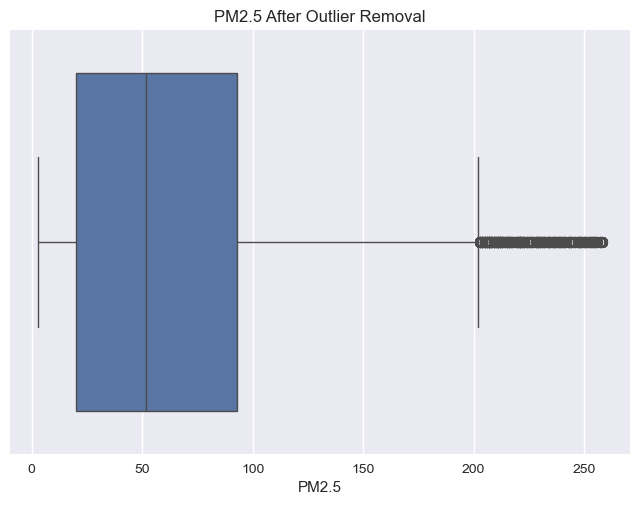

In [7]:
df = pd.read_csv('../results/outputs/handled_missing_data.csv')
numeric_cols = df.select_dtypes(include="number").columns

# Boxplot before
sns.boxplot(x=df['PM2.5'])
plt.title("PM2.5 Before Outlier Removal")
plt.savefig('../results/eda_visualizations/boxplot_pm25_before.png')
plt.show()

# IQR method for outlier removal
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
condition = ~(((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1))
df_cleaned = df[condition]

# Boxplot after
sns.boxplot(x=df_cleaned['PM2.5'])
plt.title("PM2.5 After Outlier Removal")
plt.savefig('../results/eda_visualizations/boxplot_pm25_after.png')
plt.show()

df_cleaned.to_csv('../results/outputs/handled_outliers.csv', index=False)


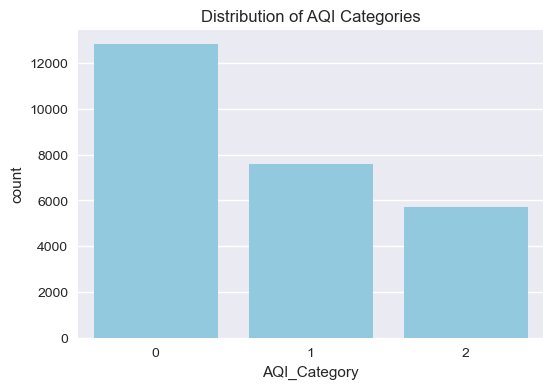

In [8]:
df = pd.read_csv('../results/outputs/handled_outliers.csv')

def aqi_category(pm25):
    if pm25 <= 50: return 0
    elif pm25 <= 100: return 1
    else: return 2

df['AQI_Category'] = df['PM2.5'].apply(aqi_category)

# EDA
plt.figure(figsize=(6,4))
sns.countplot(x='AQI_Category', data=df, color='skyblue')
plt.title("Distribution of AQI Categories")
plt.savefig('../results/eda_visualizations/aqi_category_distribution.png')
plt.show()

df.to_csv('../results/outputs/target_created.csv', index=False)


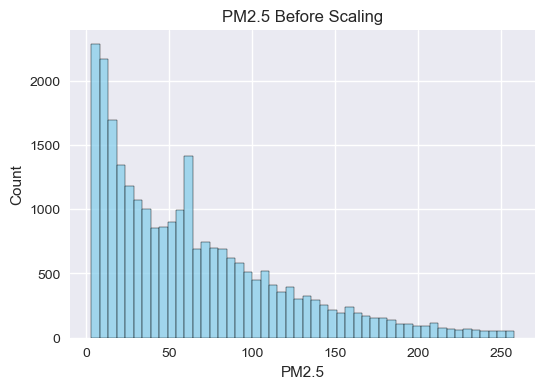

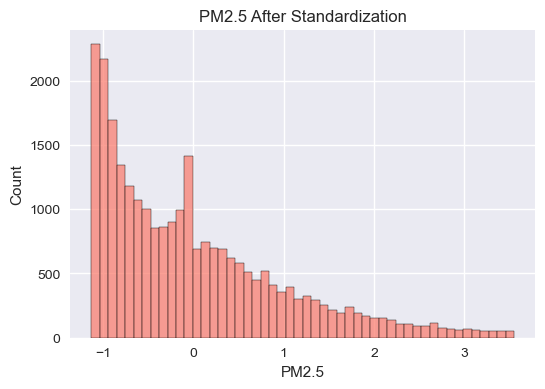

In [9]:
df = pd.read_csv('../results/outputs/target_created.csv')
feature_cols = df.drop(columns=['AQI_Category']).select_dtypes(include='number').columns

# Before scaling
plt.figure(figsize=(6,4))
sns.histplot(df['PM2.5'], bins=50, color='skyblue')
plt.title("PM2.5 Before Scaling")
plt.savefig('../results/eda_visualizations/pm25_before_scaling.png')
plt.show()

# StandardScaler
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

# After scaling
plt.figure(figsize=(6,4))
sns.histplot(df_scaled['PM2.5'], bins=50, color='salmon')
plt.title("PM2.5 After Standardization")
plt.savefig('../results/eda_visualizations/pm25_after_scaling.png')
plt.show()

df_scaled.to_csv('../results/outputs/scaled_data.csv', index=False)


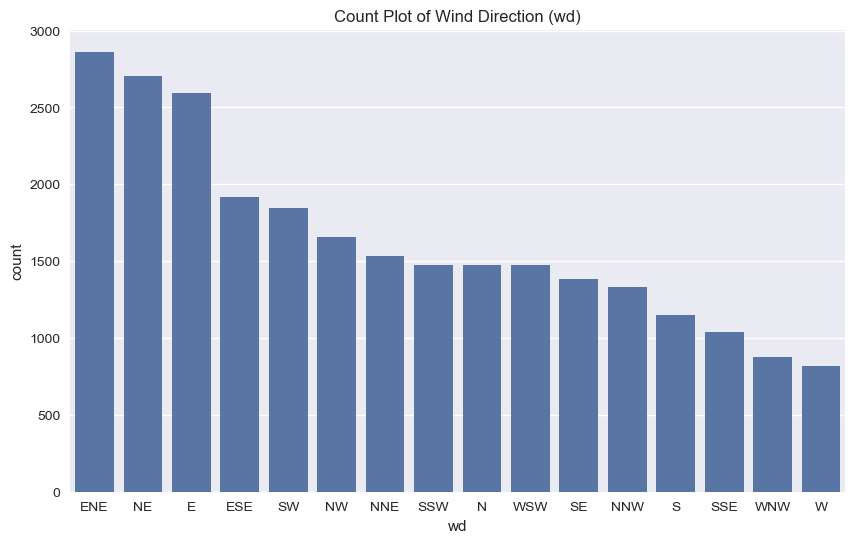

In [10]:
df = pd.read_csv('../results/outputs/scaled_data.csv')
cat_cols = df.select_dtypes(include='object').columns

# Fill missing and encode
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

if 'wd' in df.columns:
    plt.figure(figsize=(10,6))
    sns.countplot(data=df, x='wd', order=df['wd'].value_counts().index)
    plt.title("Count Plot of Wind Direction (wd)")
    plt.savefig('../results/eda_visualizations/wd_countplot.png')
    plt.show()

df_encoded = pd.get_dummies(df, columns=cat_cols, prefix=cat_cols)
df_encoded.to_csv('../results/outputs/encoded_data.csv', index=False)


Top 10 features: ['PM2.5', 'PM10', 'CO', 'SO2', 'DEWP', 'NO2', 'No', 'PRES', 'O3', 'TEMP']


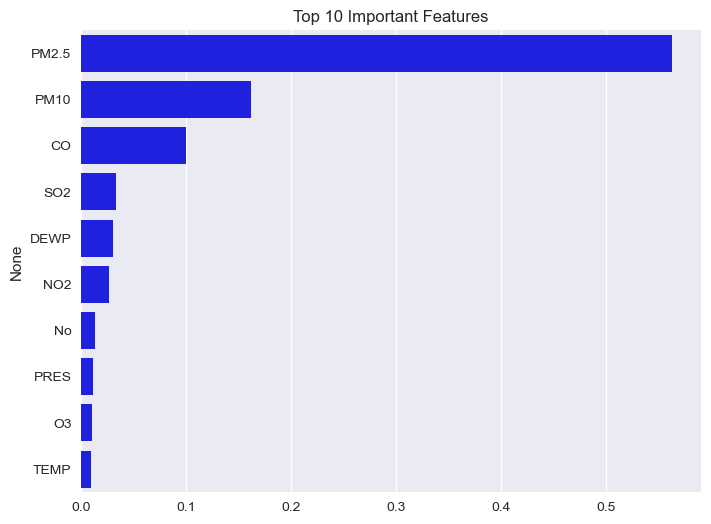

In [11]:
df = pd.read_csv('../results/outputs/encoded_data.csv')
X = df.drop(columns=['AQI_Category'])
y = df['AQI_Category']

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = importances.head(10)
print("Top 10 features:", list(top_features.index))

plt.figure(figsize=(8,6))
sns.barplot(x=top_features.values, y=top_features.index, color='blue')
plt.title("Top 10 Important Features")
plt.savefig('../results/eda_visualizations/feature_importance.png')
plt.show()

X_selected = df[top_features.index]
df_selected = pd.concat([X_selected, y], axis=1)
df_selected.to_csv('../results/outputs/selected_features.csv', index=False)


Explained variance ratio: [0.35490703 0.30721687 0.10999158 0.09275664 0.04152989]


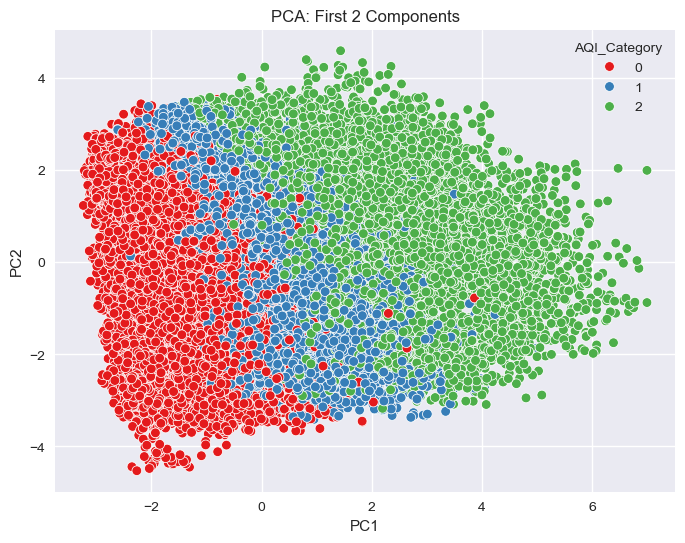

In [12]:
df_selected = pd.read_csv('../results/outputs/selected_features.csv')
X = df_selected.drop('AQI_Category', axis=1)
y = df_selected['AQI_Category']

pca = PCA(n_components=min(5, X.shape[1]))
X_pca = pca.fit_transform(X)

print("Explained variance ratio:", pca.explained_variance_ratio_)

df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_pca['AQI_Category'] = y.values

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='AQI_Category', palette='Set1')
plt.title('PCA: First 2 Components')
plt.savefig('../results/eda_visualizations/pca_scatter.png')
plt.show()

df_pca.to_csv('../results/outputs/pca_transformed_data.csv', index=False)
